# Probabilistic-Matrix-Factorization

- [Repositorio](https://github.com/fuhailin/Probabilistic-Matrix-Factorization/tree/master)

- [Paper](https://proceedings.neurips.cc/paper_files/paper/2007/hash/d7322ed717dedf1eb4e6e52a37ea7bcd-Abstract.html)

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split
import nbformat as nbf
import pathlib, os
from pathlib import Path
import pandas as pd
from sklearn.decomposition import TruncatedSVD

## 1. Cargar BD 'u.data'

    Unicamente devuelve las columnas user_id, item_id, rating

In [37]:
rating_data_path = Path("data/u.data")
genre_data_path = Path("data/u.genre")
item_data_path = Path("data/u.item")

In [38]:
def load_rating_data(path: Path):
    """
    Carga u.data, devuelve array Nx3: [user, item, rating] en float64, IDs base 0
    """
    data = np.loadtxt(path, dtype=np.int64)
    data[:, 0] -= 1  # user IDs base 0
    data[:, 1] -= 1  # item IDs base 0
    return data[:, :3].astype(np.float64)

In [39]:
ratings = load_rating_data(rating_data_path)

# Número de usuarios y items
n_users = int(ratings[:, 0].max()) + 1
n_items = int(ratings[:, 1].max()) + 1
print(f"Ratings: {ratings.shape}, usuarios={n_users}, items={n_items}")

Ratings: (100000, 3), usuarios=943, items=1682


In [40]:
def load_genre_data(path: Path):
    """
    Carga u.genre, devuelve diccionario {genre_name: genre_id}
    """
    genre_dict = {}
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if line:  # ignora líneas vacías
                name, idx = line.split("|")
                genre_dict[name] = int(idx)
    return genre_dict

In [41]:
genres = load_genre_data(genre_data_path)
print("Géneros:", genres)

Géneros: {'unknown': 0, 'Action': 1, 'Adventure': 2, 'Animation': 3, "Children's": 4, 'Comedy': 5, 'Crime': 6, 'Documentary': 7, 'Drama': 8, 'Fantasy': 9, 'Film-Noir': 10, 'Horror': 11, 'Musical': 12, 'Mystery': 13, 'Romance': 14, 'Sci-Fi': 15, 'Thriller': 16, 'War': 17, 'Western': 18}


In [43]:
def load_item_data(path: Path):
    """
    Carga u.item, devuelve dataframe con:
    movieId (base 0), title, genres (19 columnas binarias)
    """
    df = pd.read_csv(path, sep='|', header=None, encoding='latin-1')
    movie_ids = df[0].values - 1        # base 0
    titles = df[1].values               # título
    genre_matrix = df.iloc[:, 5:24].values.astype(int)  # columnas de géneros 0/1
    return movie_ids, titles, genre_matrix

In [44]:
item_ids, titles, genre_matrix = load_item_data(item_data_path)
print("Número de items cargados:", len(item_ids))
print("Ejemplo título:", titles[0])
print("Ejemplo géneros (vector binario):", genre_matrix[0])

Número de items cargados: 1682
Ejemplo título: Toy Story (1995)
Ejemplo géneros (vector binario): [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 2. Train /test

    Dividir el dataset en train (80%) y test(20%)

In [51]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
print("Train:", train.shape, "Test:", test.shape)

Train: (80000, 3) Test: (20000, 3)


## 3. Definir PMF

    (La Clase PMF es igual que la del repositorio)

In [46]:
# -*- coding: utf-8 -*-
import numpy as np


class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # 评分平均值

        pairs_train = train_vec.shape[0]  # traindata 中条目数
        pairs_test = test_vec.shape[0]  # testdata中条目数

        # 1-p-i, 2-m-c
        #num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # 第0列，user总数
        #num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # 第1列，movie总数
        num_user = int(np.max(np.concatenate([train_vec[:, 0], test_vec[:, 0]]))) + 1
        num_item = int(np.max(np.concatenate([train_vec[:, 1], test_vec[:, 1]]))) + 1

        incremental = False  # 增量
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn 电影 M x D 正态分布矩阵
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn 用户 N x D 正态分布矩阵

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  # 创建电影 M x D 0矩阵
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # 创建用户 N x D 0矩阵

        while self.epoch < self.maxepoch:  # 检查迭代次数
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # 根据记录数创建等差array
            np.random.shuffle(shuffled_order)  # 用于将一个列表中的元素打乱

            # Batch update
            for batch in range(self.num_batches):  # 每次迭代要使用的数据量
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # 本次迭代要使用的索引下标

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply对应位置元素相乘

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort索引排序

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)

## 4. Definir modelo PMF

    Mismos parámetros de entrada que en el repo

In [120]:
pmf = PMF()
num_feat = 10
pmf.set_params({
    "num_feat": num_feat,
    "epsilon": 1,
    "_lambda": 0.01,
    "momentum": 0.8,
    "maxepoch": 100,     # en el código tienen 10 pero luego en el README 100
    "num_batches": 10,
    "batch_size": 1000,
})

In [121]:
if num_feat <= genre_matrix.shape[1]:
    svd = TruncatedSVD(n_components=num_feat, random_state=42)
    pmf.w_Item = svd.fit_transform(genre_matrix)
else:
    pmf.w_Item = np.zeros((genre_matrix.shape[0], num_feat))
    pmf.w_Item[:, :genre_matrix.shape[1]] = genre_matrix
    pmf.w_Item[:, genre_matrix.shape[1]:] = 0.01 * np.random.randn(genre_matrix.shape[0], num_feat - genre_matrix.shape[1])

# Inicializar w_User aleatoriamente
pmf.w_User = 0.1 * np.random.randn(n_users, num_feat)

### Entrenar modelo

In [122]:
pmf.fit(train, test)

Training RMSE: 1.126459, Test RMSE 1.124511
Training RMSE: 1.126187, Test RMSE 1.124497
Training RMSE: 1.125920, Test RMSE 1.124496
Training RMSE: 1.125645, Test RMSE 1.124491
Training RMSE: 1.125369, Test RMSE 1.124487
Training RMSE: 1.125088, Test RMSE 1.124467
Training RMSE: 1.124817, Test RMSE 1.124455
Training RMSE: 1.124545, Test RMSE 1.124452
Training RMSE: 1.124265, Test RMSE 1.124439
Training RMSE: 1.123975, Test RMSE 1.124418
Training RMSE: 1.123685, Test RMSE 1.124405
Training RMSE: 1.123383, Test RMSE 1.124392
Training RMSE: 1.123056, Test RMSE 1.124362
Training RMSE: 1.122732, Test RMSE 1.124335
Training RMSE: 1.122388, Test RMSE 1.124283
Training RMSE: 1.122021, Test RMSE 1.124241
Training RMSE: 1.121635, Test RMSE 1.124195
Training RMSE: 1.121232, Test RMSE 1.124123
Training RMSE: 1.120802, Test RMSE 1.124038
Training RMSE: 1.120346, Test RMSE 1.123928
Training RMSE: 1.119855, Test RMSE 1.123778
Training RMSE: 1.119334, Test RMSE 1.123632
Training RMSE: 1.118777, Test RM

### Visualizar 


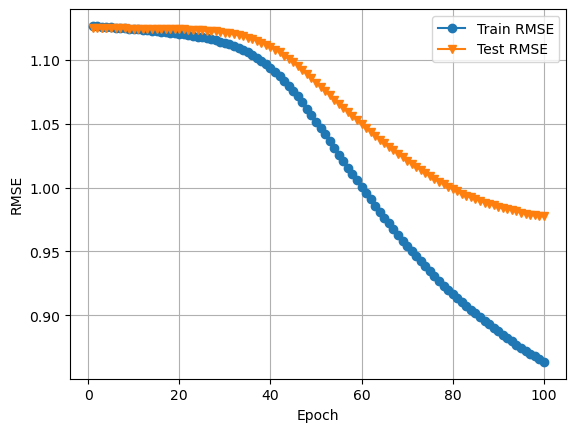

In [123]:
plt.plot(range(1, len(pmf.rmse_train)+1), pmf.rmse_train, marker='o', label='Train RMSE')
plt.plot(range(1, len(pmf.rmse_test)+1), pmf.rmse_test, marker='v', label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

### Evaluar 

In [124]:
prec, rec = pmf.topK(test, k=100)
print(f"Top-100 Precision: {prec:.4f}, Recall: {rec:.4f}")

Top-100 Precision: 0.0407, Recall: 0.2130


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split

import nbformat as nbf
import pathlib, os